In [1]:
import os
os.environ['GEMS_HOME'] = '/home/cogito/GEMS_python'

# MODIS 01

In [31]:
### Package Import
import sys
import os
base_dir = os.environ['GEMS_HOME']
project_path = os.path.join(base_dir, 'python-refactor')
sys.path.insert(0, project_path)
from Code.utils import matlab

import numpy as np
import glob
from osgeo import gdal
import subprocess
import tempfile

### Setting path
data_base_dir = os.path.join(project_path, 'Data')
raw_modis_path = os.path.join(data_base_dir, 'Raw', 'MODIS', 'MCD12Q1') 
path_mosaic = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS', '01mosaic') #workspace = os.path.join(work_path, '01_mosaic')
tmpdirname = tempfile.TemporaryDirectory(dir=base_dir)  # will be deleted

flist = glob.glob(os.path.join(raw_modis_path, "*.hdf"))
flist.sort()
nfile = len(flist)

In [32]:
for k in range(0,nfile,14):
    flist_temp = flist[k:k+14]
    yr = os.path.basename(flist_temp[0])[9:13]
    
    input_files = [] 
    for m in range(0,14):
        fname = flist_temp[m]
        dst_dataset = os.path.join(tmpdirname.name, f"LC_{yr}_{m+1}.tif")
        
        gdal_dataset = gdal.Open(os.path.join(raw_modis_path, fname))
        src_dataset = gdal_dataset.GetSubDatasets()[0][0]
        subprocess.call(["gdal_translate", src_dataset, dst_dataset])
        input_files.append(dst_dataset)
    
    # Mosaic
    matlab.check_make_dir(path_mosaic) # debugging
    dst_fname = os.path.join(path_mosaic, f"EA_MCD12Q1_mosaic_{yr}.tif")
    pixel_type = 'Int16'
    in_nodata_val = "255"
    out_nodata_val = "-9999"
    compression = "COMPRESS=LZW"
    
    cmd = ["gdal_merge.py", "-n", in_nodata_val, "-a_nodata", out_nodata_val, "-ot", pixel_type]
    cmd += ["-co", compression]
    cmd += ["-o", dst_fname]
    cmd += input_files
    subprocess.call(cmd)
    
    tmpdirname.cleanup()
    print (os.path.basename(dst_fname))

2016


In [33]:
import rasterio as rio
from rasterio.plot import show

In [34]:
data = rio.open(dst_fname)

In [35]:
data.read(1)

array([[    3,     3,     8, ..., -9999, -9999, -9999],
       [    3,     3,     3, ..., -9999, -9999, -9999],
       [    3,     3,     3, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ...,    17,    17,    17],
       [-9999, -9999, -9999, ...,    17,    17,    17],
       [-9999, -9999, -9999, ...,    17,    17,    17]], dtype=int16)

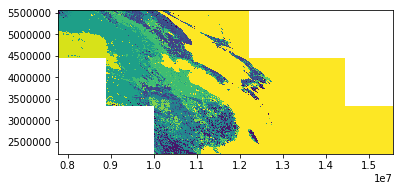

In [36]:
show(data)

In [37]:
data2 = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/01mosaic/EA_MCD12Q1_mosaic_2016_arcpy.tif')

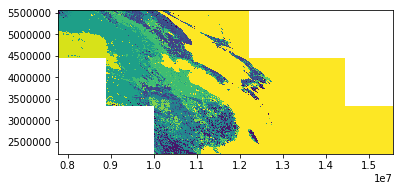

In [38]:
show(data2)

In [39]:
arr = data2.read(1)
arr[arr==255] = -9999

np.all(arr==data.read(1))

# MODIS 02

In [30]:
### Package Import
import sys
import os
base_dir = os.environ['GEMS_HOME']
project_path = os.path.join(base_dir, 'python-refactor')
sys.path.insert(0, project_path)
from Code.utils import matlab

import glob
import time 
import tempfile
import rasterio as rio
from rasterio.warp import (
    calculate_default_transform, 
    aligned_target,
    reproject, 
    Resampling
)

In [31]:
### Setting path
data_base_dir = os.path.join(project_path, 'Data')
path_mosaic = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS')
mask = os.path.join(data_base_dir, 'Raw', 'mask', 'r_rec_N50W110S20E150.tif')

flist = glob.glob(os.path.join(path_mosaic, '01mosaic', "*.tif"))
flist.sort()

In [45]:
for src_dataset in flist:
    last_num = os.path.basename(src_dataset)[-8:] # b 2016.tif
    print (src_dataset)
    
    matlab.check_make_dir(os.path.join(path_mosaic, '02prj_GCS_WGS84')) # debugging
    matlab.check_make_dir(os.path.join(path_mosaic, '03masked_N50W110S20E150')) # debugging
    
    dst_dataset02 = os.path.join(path_mosaic, '02prj_GCS_WGS84', f'GCS_EA_MCD12Q1_{last_num}') # c
    dst_dataset03 = os.path.join(path_mosaic, '03masked_N50W110S20E150', f'm_MODIS_LC_500m_{last_num}') # d

    dst_crs = 'EPSG:4326'
    resolution = 5.11542231032757E-03
    with rio.open(src_dataset) as src:
        transform, width, height = calculate_default_transform(
                src.crs, dst_crs, 
                src.width, src.height, *src.bounds, 
                resolution=resolution)
        transform, width, height = aligned_target(
                transform, width, height, resolution)

        kwargs = src.meta.copy()
        kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height,
                'nodata':-9999,
                'compress':'LZW',
        })

        with rio.open(dst_dataset02, 'w', **kwargs) as dst:
            for i in range(1, src.count+1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    src_nodata=-9999,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    dst_nodata=-9999,
                    dst_resolution=resolution,
                    resampling=Resampling.nearest,

                )
    print (os.path.basename(dst_dataset02))

/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/01mosaic/EA_MCD12Q1_mosaic_2016.tif
GCS_EA_MCD12Q1_2016.tif


In [46]:
import rasterio as rio
from rasterio.plot import show

(1, 5866, 20627)
[[[-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  ...
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]]]


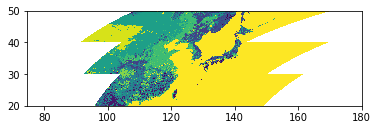

In [47]:
data = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/02prj_GCS_WGS84/GCS_EA_MCD12Q1_2016.tif')
arr = data.read()
print (arr.shape)
print (arr)

show(data)

(1, 5866, 20627)
[[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]]


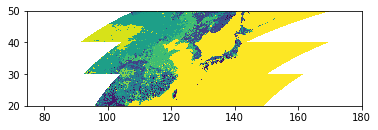

In [48]:
data2 = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/02prj_GCS_WGS84/GCS_EA_MCD12Q1_2016_arcpy.tif')

arr2 = data2.read()
print (arr2.shape)
print (arr2)

show(data2)

In [49]:
import numpy as np

In [50]:
arr2[arr2==255] = -9999

np.all(arr==arr2)

False

Text(0.5, 1.0, 'Arcpy result')

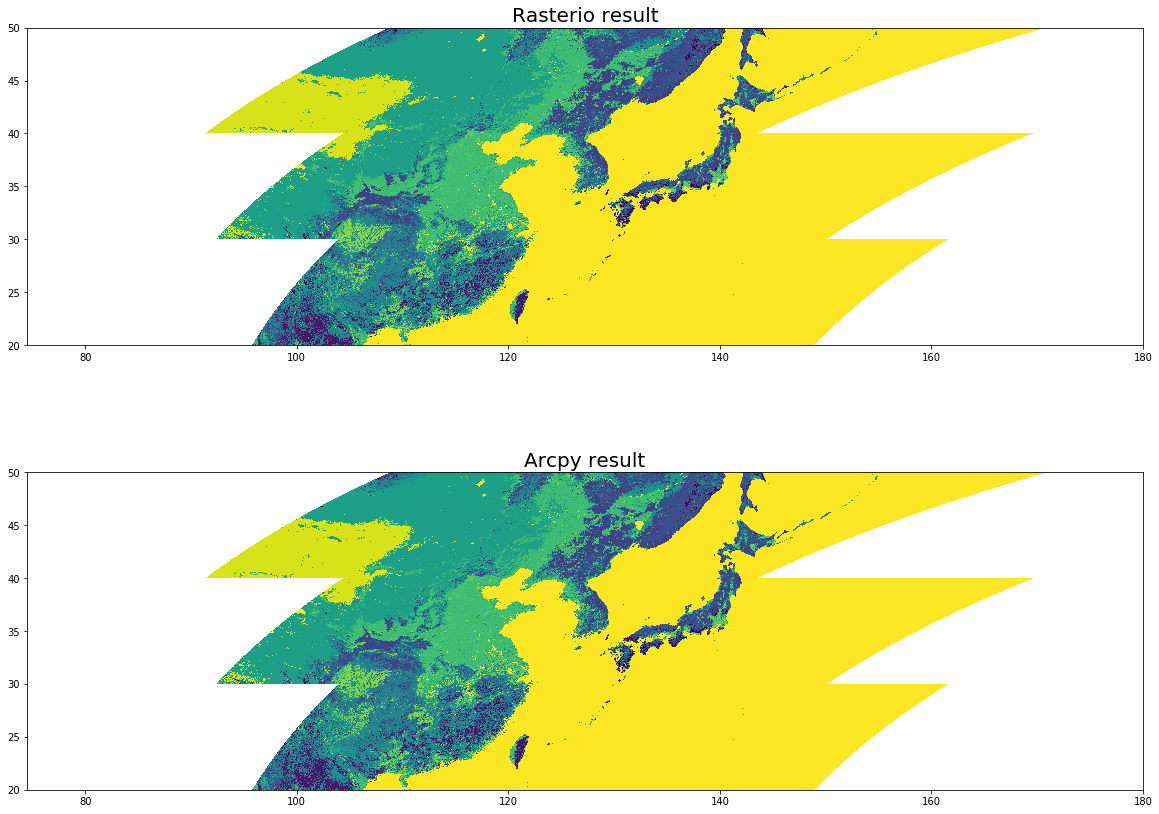

In [103]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1, figsize=(20, 15))
show(data, ax=axs[0])
axs[0].set_title('Rasterio result', fontsize=20)
show(data2, ax=axs[1])
axs[1].set_title('Arcpy result', fontsize=20)